In [188]:
lookback = 10
avg_offset = 10 # takes mean over signals avg_window in the past to avg_window in the future
avg_window_0d=10
avg_window_1d=3
delay = 1

In [189]:
import numpy as np
import pickle
import copy

In [190]:
import matplotlib.pyplot as plt
%matplotlib inline

In [191]:
dirname='/global/homes/a/abbatej/'
with open(dirname+'final_data.pkl', 'rb') as f: 
    raw_data=pickle.load(f, encoding='latin1')

In [192]:
num_train_shots=700
num_val_shots=200

In [193]:
shots = sorted(raw_data.keys())

In [194]:
raw_data[160947].keys()

dict_keys(['elongation_up', 'curr', 'i_temp', 'e_temp', 'pinj', 'triangularity_up', 'curr_target', 'drsep', 'elongation_low', 'e_dens', 'Z0', 'tinj', 'i_dens', 'R0', 'zeta_in_up', 'epsilon', 'zeta_out_up', 'press', 'rotation', 'triangularity_low', 'zeta_in_low', 'gasA', 'gasB', 'q', 'time', 'R_geo', 'zeta_out_low'])

In [195]:
# specify the signals we want
sigs_1d = sorted(['e_temp'])
sigs_0d = sorted(['tinj', 'pinj', 'curr_target'])#, 'gasA'])
sigs = sigs_0d+sigs_1d

In [196]:
# average over the previous avg_window timesteps 
def smooth_signal(sig, avg_window):
    return np.array([np.mean(sig[ind-avg_window:ind],axis=0) for ind in range(avg_offset, len(sig))])

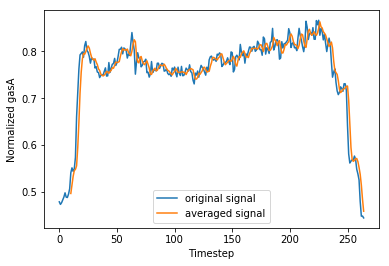

In [197]:
sig=np.mean(raw_data[shots[0]]['e_temp'],axis=1)

new_data=smooth_signal(sig, avg_window_1d)
plt.plot(sig, label='original signal')
plt.plot(list(range(avg_offset,len(sig))),new_data,label='averaged signal')
plt.xlabel('Timestep')
plt.ylabel('Normalized gasA')
plt.legend()
plt.show()

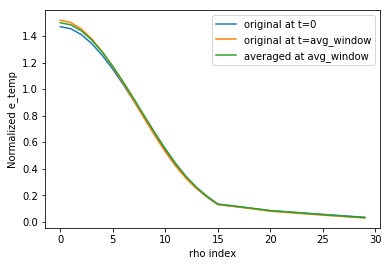

In [198]:
sig=raw_data[shots[0]]['e_temp']

new_data=smooth_signal(sig, avg_window)
plt.plot(sig[0], label='original at t=0')
plt.plot(sig[avg_window_1d], label='original at t=avg_window')
plt.plot(new_data[0],label='averaged at avg_window')
plt.xlabel('rho index')
plt.ylabel('Normalized e_temp')
plt.legend()
plt.show()

In [199]:
# first get the indices that contain all the data we need
# (both train and validation)
train_shots=[]
val_shots=[]
for shot in shots:
    if set(sigs).issubset(raw_data[shot].keys()):
        if (len(train_shots)<num_train_shots):
            train_shots.append(shot)
        elif (len(val_shots)<num_val_shots):
            val_shots.append(shot)
        else:
            break

In [200]:
# smooth each signal
data={}
for shot in (train_shots+val_shots):
    data[shot]={}
    for sig in sigs_0d:
        data[shot][sig] = smooth_signal(raw_data[shot][sig],avg_window_0d)
    for sig in sigs_1d:
        data[shot][sig] = smooth_signal(raw_data[shot][sig],avg_window_1d)

In [201]:
count=0
for shot in (train_shots+val_shots):
    if data[shot]['e_temp'].size==0:
        count+=1
        data.pop(shot,None)
        if shot in train_shots:
            train_shots.remove(shot)
        if shot in val_shots:
            val_shots.remove(shot)
print('Removed '+str(count)+' shots with empty arrays')

Removed 15 shots with empty arrays


In [202]:
means={}
stds={}

for sig in sigs:
    means[sig] = np.nanmean(np.array([np.nanmean(data[shot][sig], axis=0) for shot in train_shots]),axis=0)
    stds[sig] = np.nanstd(np.array([np.nanmean(data[shot][sig],axis=0) for shot in train_shots]),axis=0)

In [203]:
print(means)
print(stds)

{'curr_target': 1059772.3698266281, 'pinj': 4396.059190843108, 'tinj': 3.0656344063782472, 'e_temp': array([2.72496718, 2.70040672, 2.63075942, 2.5223395 , 2.38182511,
       2.21619364, 2.03265169, 1.83853969, 1.64113009, 1.44755513,
       1.26420869, 1.09642931, 0.94768945, 0.81841975, 0.70310468,
       0.55612927, 0.51616095, 0.46724409, 0.4069781 , 0.33496574,
       0.25680508, 0.21459979, 0.17556081, 0.14111224, 0.11201151,
       0.08841685, 0.06980891, 0.05541257, 0.04431161, 0.03574572])}
{'curr_target': 204211.8497935658, 'pinj': 2150.522843653218, 'tinj': 1.8072916361387679, 'e_temp': array([0.79977295, 0.79311793, 0.77446509, 0.74614659, 0.71077671,
       0.6710566 , 0.62954685, 0.58841084, 0.54916629, 0.5123446 ,
       0.4778491 , 0.44531485, 0.41484039, 0.38711051, 0.35971375,
       0.30415895, 0.28621839, 0.26308376, 0.23178658, 0.19169503,
       0.1471971 , 0.12246363, 0.09885103, 0.0774103 , 0.05915408,
       0.04467744, 0.03391986, 0.02634426, 0.02113032, 0.017

In [204]:
def normalize(obj, mean, std):
    return (obj-mean)/std

def make_final_data(my_shots):
    final_data=[]
    final_target=[]
    for shot in my_shots:
        num_timesteps=len(data[shot][sigs[0]])
        
        for end_time in range(lookback, num_timesteps-delay):
            final_data.append([])
            final_target.append([])
            
            for sig in sigs_1d:
                final_target[-1].extend(normalize(data[shot][sig][end_time+delay], means[sig], stds[sig]))
            
            for time in range(end_time-lookback,end_time):
                final_data[-1].append([])
                for sig in sigs_0d:
                    # used to be time+delay below because the 0d signals are actuators
                    new_sig = normalize(data[shot][sig][time], means[sig], stds[sig])
                    final_data[-1][-1].append(new_sig)
                for sig in sigs_1d:
                    new_sig = normalize(data[shot][sig][time], means[sig], stds[sig])
                    final_data[-1][-1].extend(new_sig)
    return (np.array(final_data), np.array(final_target))

train_tuple = make_final_data(train_shots)
train_data = train_tuple[0]
train_target = train_tuple[1]

val_tuple = make_final_data(val_shots)
val_data = val_tuple[0]
val_target = val_tuple[1]

In [205]:
# note the shape reflects (num_samples, lookback, num_features)
# num_features has 22 rho values for each 1d sig and 1 value for each 0d sig
print(np.array(raw_data[shots[0]]['pinj']).shape)
print(train_data.shape)

(265,)
(132090, 10, 33)


In [206]:
with open(dirname+'train_data.pkl', 'wb') as f: 
    pickle.dump(train_data, f)

In [207]:
with open(dirname+'train_target.pkl', 'wb') as f: 
    pickle.dump(train_target, f)

In [208]:
with open(dirname+'val_data.pkl', 'wb') as f: 
    pickle.dump(val_data, f)

In [209]:
with open(dirname+'val_target.pkl', 'wb') as f: 
    pickle.dump(val_target, f)

In [210]:
with open(dirname+'means.pkl', 'wb') as f: 
    pickle.dump(means, f)

In [211]:
with open(dirname+'stds.pkl', 'wb') as f: 
    pickle.dump(stds, f)

In [212]:
train_indices=np.cumsum([len(raw_data[shot]['e_temp'])-avg_window-delay-lookback for shot in train_shots])
train_indices=np.insert(train_indices,0,0)
val_indices=np.cumsum([len(raw_data[shot]['e_temp'])-avg_window-delay-lookback for shot in val_shots])
val_indices=np.insert(val_indices,0,0)

In [213]:
def get_time_values(my_shots):
    times=[]
    for shot in my_shots:
        num_timesteps=len(data[shot][sigs[0]])
        for time in range(lookback, num_timesteps-delay):
            # used to be time+delay below because the 0d signals are actuators
            time = raw_data[shot]['time'][time]
            times.append(time)
    return times

val_time_values=get_time_values(val_shots)
train_time_values=get_time_values(train_shots)

In [214]:
with open(dirname+'train_time.pkl', 'wb') as f: 
    pickle.dump(train_time_values, f)

In [215]:
with open(dirname+'val_time.pkl', 'wb') as f: 
    pickle.dump(val_time_values, f)

In [216]:
shot_indices={'train_shot_indices': train_indices,
             'val_shot_indices': val_indices,
             'train_shot_names': train_shots,
             'val_shot_names': val_shots}

In [217]:
with open(dirname+'shot_indices.pkl', 'wb') as f: 
    pickle.dump(shot_indices, f)

In [218]:
len(val_indices)

200